In [1]:
import string
import os
import sys
import random
from typing import List, Dict, Tuple
from pathlib import Path

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as f
from torchvision import datasets
from torchmetrics.functional import char_error_rate
from torchinfo import summary

from IPython.display import clear_output, display
from matplotlib import pyplot as plt
from PIL import Image

import pandas as pd
from collections import Counter

%matplotlib notebook

Зафиксируем сиды.

**NOTE**: это, к сожалению, не приведёт к воспроизводимости кода - `CTCLoss` в `Pytorch` не умеет работать детерминированно ([ссылка](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html)). Отметим, однако, что в [документации](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html#torch.nn.CTCLoss) к `CTCLoss` написано, что изменение `torch.backends.cudnn.deterministic=True` приведёт к выбору детерминированного алгоритма, что некорректно - согласно [этой](https://stackoverflow.com/questions/66130547/what-does-the-difference-between-torch-backends-cudnn-deterministic-true-and) ссылке данный параметр влияет только на детерминированность вычисления свёрток.

Невозможность выбора детерминированного алгоритма несколько странна, поскольку такой алгоритм поддерживается `cuDNN` - [вот](https://docs.nvidia.com/deeplearning/cudnn/api/index.html#cudnnCTCLossAlgo_t). Проверим наличие `cuDNN`...

In [2]:
torch.backends.cudnn.enabled

True

Как-то так.

In [3]:
seed = 42069

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Будем имплементировать `CRNN` согласно [этой](https://arxiv.org/pdf/1507.05717.pdf) статье.
В качестве лосса пока будем использовать предложенный там `CTCLoss`.

Отметим, что в статье есть небольшие ошибки - для картинки размером `100x32` в рекуррентный слой будет подаваться последовательность не длины 25, а длины 24. Также отметим, что каждый элемент последовательности содержит информацию не о прямоугольной области, а немного искривлённой из-за `MaxPooling`-слоёв, которые просто так убирать не стоит - если так сделать, то соседние элементы последовательности будут отличаться всего на 2 (крайних) столбца, и мы будем таскать с собой много повторяющейся информации. 

Ещё один интересный момент, связанный с `MaxPooling`-слоями - размер `stride`. Изначально мы допустили ошибку, поставив `stride=2`, но сеть всё ещё обучалась, при том даже немного быстрее. Этот вариант, тем не менее, был отвергнут, поскольку результирующая последовательность для картинки шириной `100` будет длиной всего `6`, а это вызовет проблемы при декодировании, которые опишем далее.

Отметим, что для предсказания повторяющихся подряд идущих символов нужна бОльшая длина последовательности. Так, для капчи `cd5ff` одним из вариантов правильного предсказания будет `cd5f-f`, а `cd5ff` будет неправильно, поскольку последовательные повторения убираются (т.о., получится `cd5f`). Худшим случаем, очевидно, будет последовательность из одинаковых символов, например, `fffff`, для которой минимальная описывающая последовательность имеет вид `f-f-f-f-f`, которая имеет длину 9.

К сожалению, мы, скорее всего, допустили какие-то ошибки при реализации модели согласно статье - заявленное число параметров (8.3м) не соответствует тому, что получили мы (8.7м). Однако, мы всё же убеждены в том, что имплементированное решение достаточно неплохо подходит для решения поставленной задачи, в чём мы также убедимся чуть далее.

В нашем решении, конечно же, есть некоторые явные недостатки:

1. Размер выходной последовательности. В датасете встречаются очень длинные последовательности, которые точно больше 25. Мы не сможем их разрешить при текущей архитектуре сети. С другой стороны, их не так много, а задание такого внушительного количества размера последовательности может ухудшить сходимость, поскольку `CTCLoss` очень любит локальный минимум, когда выдаются только blank-токены (в нашем случае '\'). Большой размер последовательности может существенно замедлить сходимость.

2. Размер словаря. Много символов почти не встречаются в датасете (это можно будет увидеть в EDA). Мы берём только @180 символов в словарь. Это не позволит нам разрешить какие-то последовательности. Более того, включение таких данных в тренировочный набор недопустимо, поскольку у них нет индексов. Благо их не так много и их можно спокойно откинуть.

3. Обработка данных. Некоторые последовательности даны в довольно плохом качестве (настолько, что глазу автора решения нередко непонятно, что написано на картинке, на таких примерах не ожидается хороший результат модели). Какие-то последовательности повёрнуты на 180 градусов, а какие-то на 90/270 (идут сверху-вниз/снизу-вверх). Мы не придумали, как определить картинки первого типа и они, насколько мы понимаем, не очень хорошо впишутся в архитектуру. Для картинок 2 типа сделана базовая предобработка (если высота больше ширины на какой-то коэффициент - надо перевернуть картинку на 90 градусов). Это сгладит проблему, но не решит её полностью и это, определённо, плохо. По поводу типа 2 хотелось ещё попробовать поставить в параллель рекуррентному слою ещё один, который бы обрабатывал фичи со свёрточных слоёв горизонтально (по ширине, а не высоте, как в статье), а потом их (например) складывать. К сожалению, времени на это не хватило, так что оставим эту идею на будущее.

Тем не менее, даже так мы смогли достичь достаточно хороших результатов в рамках задачи, что станет понятно по содержанию ноутбука.

Из положительного ещё считаем важным отметить работы по оптимизации времени обучения - удалось снизить время обучения с 1.5 часов до ~10 минут на эпоху. Для этого были предприняты следующие шаги:

    - Загрузка картинок с помощью [Pillow-SIMD](https://github.com/uploadcare/pillow-simd). Это сократило время обучения примерно на 10%;
    - Работа с параметрами DataLoader-а. Наш процессор позволил запустить даталоадер `num_workers = 16`.

In [6]:
class OCRTrainDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root_dir: str = os.path.join('..', 'data', 'raw', 'vk-made-ocr'),
        desired_width: int = 80,
        desired_height: int = 32,
        pad_token = '\\',
        mode='train',
        vocab_size = 180,
        limit=-1,
    ):
        super().__init__()
        self.root_dir = root_dir
        self.mode = 'train'
        self.path = Path(os.path.join(root_dir, mode, mode))
        self.width = desired_width
        self.height = desired_height
        self.limit = limit
        self.labels = pd.read_csv(os.path.join(root_dir, 'train_labels.csv')).fillna('')
        
        self.pad_token = pad_token
        self.vocab_size = vocab_size
        self.id_2_char = None
        self.char_2_id = None
        
        chars_in_dataset = Counter(''.join(self.labels['Expected'].values))
        self.fill_vocabs(chars_in_dataset)
        self.clean_labels(chars_in_dataset)
        
        if self.limit != -1:
            self.labels = self.labels.iloc[:self.limit]
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx: int):
        path = self.path / self.labels.iloc[idx]['Id']
        
        with Image.open(path) as image_pil:
            image = image_pil \
                if image_pil.size[0] / image_pil.size[1] > 0.8 \
                else image_pil.transpose(Image.ROTATE_90)
            image = image.resize((self.width, self.height))
            image = torch.from_numpy(np.array(image).astype(np.float32) / 255).unsqueeze(0)
        
        image = image.permute((0, 3, 1, 2))
        
        target = [self.char_2_id[x] for x in self.labels.iloc[idx]['Expected']]
        target = torch.tensor(target, dtype=torch.int32)
        
        return image, target, len(target)
    
    def fill_vocabs(self, chars_in_dataset):
        '''
        Fill (id, char) and (char, id) vocabs for current dataset.
        '''
        self.id_2_char = dict(enumerate(map(lambda x: x[0], chars_in_dataset.most_common(self.vocab_size)), start=1))
        self.id_2_char[0] = self.pad_token
        self.char_2_id = {char: label for label, char in self.id_2_char.items()}
        
    def clean_labels(self, chars_in_dataset):
        '''
        Remove Out Of Vocabulary points ((image, label) pairs) from dataset
        '''
        out_of_dict_elems = set([elem for elem in chars_in_dataset.keys() if elem not in self.char_2_id])

        self.labels = self.labels[~(self.labels['Expected']
                        .map(out_of_dict_elems.intersection)
                        .map(len) > 0)].reset_index(drop=True)

In [4]:
class CRNN(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 37):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 512
        self.height = 32
        self.rnn_hidden_size = 256
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=512, out_channels=self.out_channels, kernel_size=2, stride=1, padding=0),
        )
                
        self.rec_layers = nn.LSTM(self.out_channels, self.rnn_hidden_size, bidirectional=True, num_layers=2)
        
        self.clf_layer = nn.Linear(2 * self.rnn_hidden_size, self.num_classes)
        
    def forward(self, x: torch.Tensor):
        x = self.conv_layers(x)  # Outputs (Bsize, Cnum, H, W)
        
        batch_size, ch_num, height, width = x.size()
                
        # We need to concat all channels columnwise
        x = x.view(batch_size, ch_num * height, width)
        x = x.permute(2, 0, 1)

        x, _ = self.rec_layers(x)
        x = self.clf_layer(x)
        return x  # Output is of shape (width, bsize, num_classes)

In [5]:
def get_grad_norm(model: nn.Module) -> List[float]:  # For local tests
    total_norm = 0
    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
    for p in parameters:
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [5]:
def train_model_ctc(model: nn.Module,
                    id_2_char: Dict[int, str],
                    optimizer: torch.optim.Optimizer,
                    scheduler: torch.optim.lr_scheduler._LRScheduler,
                    criterion: nn.modules.loss._Loss,
                    train_loader: torch.utils.data.DataLoader,
                    test_loader: torch.utils.data.DataLoader,
                    num_epochs: int = 100, 
                    save_every: int = -1) -> Dict[str, List[str]]:
    losses = {'train': [], 'test': []}
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    plt.ion()

    for epoch in range(num_epochs):
        model.train()
        for train_data in tqdm(train_loader):

            images, targets, target_lengths = [elem.to(device, non_blocking=True) for elem in train_data]

            logits = model(images)

            # recall that dims are (width, bsize, num_classes)
            log_probas = f.log_softmax(logits, dim=2)

            input_lengths = torch.tensor([logits.size(0)] * logits.size(1), dtype=torch.int32)

            loss = criterion(log_probas, targets, input_lengths, target_lengths)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            losses['train'].append(loss.item())
        
        if save_every != -1 and epoch >= save_every and epoch % save_every == 0:
            torch.save(model.state_dict(), f"crnn_model_{epoch}.pth")
            
        model.eval()
        with torch.no_grad():
            for test_images, test_targets, test_lengths in test_loader:
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)
                test_lengths = test_lengths.to(device)
                true_subsample = [[id_2_char[elem.item()] for elem in target] for target in test_targets[:10]]

                logits = model(test_images)

                # recall that dims are (width, bsize, num_classes)
                log_probas = f.log_softmax(logits, dim=2)

                input_lengths = torch.tensor([logits.size(0)] * logits.size(1), dtype=torch.int32)
                loss = criterion(log_probas, test_targets, input_lengths, test_lengths)

    #             pred = [[id_2_char.get(s.item(), '\\') for s in ss] for ss in torch.argmax(log_probas.permute((1, 0, 2))[:10], axis=2)]
    #             print(*zip(pred, true_subsample), sep='\n')

                losses['test'].append(loss.item())

        if scheduler is not None:
            scheduler.step()

        for ax, title in zip(axes, ['train', 'test']):
            ax.cla()
            ax.set_title(f'{title} CTC')
            ax.plot(losses[title], label=f"last_loss: {losses[title][-1]:.5f}")
            ax.legend()

        fig.canvas.draw()
        
    return losses

In [7]:
dataset_path = os.path.join('..', 'data', 'raw', 'vk-made-ocr')
mode = 'train'
train_images_path = os.path.join(dataset_path, mode, mode)
train_images_labels = os.path.join(dataset_path, 'train_labels.csv')

# EDA

## Смотрим статистики по уникальным символам

In [17]:
labels_df = pd.read_csv(train_images_labels).fillna('')
labels = labels_df['Expected'].values
chars_in_dataset = Counter(''.join(labels))

In [18]:
LABEL_TO_CHAR = dict(enumerate(map(lambda x: x[0], chars_in_dataset.most_common(180))))
# chars_in_dataset['\\']
CHAR_TO_LABEL = {char: label for label, char in LABEL_TO_CHAR.items()}
CHAR_TO_LABEL

PAD_TOKEN = '\\'

In [19]:
out_of_dict_elems = set([elem for elem in chars_in_dataset.keys() if elem not in CHAR_TO_LABEL])
out_of_dict_elems

{'\\',
 '¡',
 '£',
 '¤',
 '¥',
 '§',
 '©',
 'ª',
 '\xad',
 '¯',
 '°',
 '²',
 '³',
 '´',
 '½',
 'Â',
 'Æ',
 'È',
 'É',
 'Ë',
 'Ô',
 'Õ',
 'Ö',
 '×',
 'Ù',
 'Ü',
 'ß',
 'à',
 'á',
 'ã',
 'ä',
 'æ',
 'è',
 'é',
 'ê',
 'ì',
 'ô',
 'õ',
 'ö',
 'ü',
 'Đ',
 'ō',
 'Ƨ',
 'ɑ',
 'ɔ',
 'ʌ',
 'Α',
 'Δ',
 'Ε',
 'Η',
 'Θ',
 'Ι',
 'Κ',
 'Λ',
 'Μ',
 'Ν',
 'Ο',
 'Π',
 'Ρ',
 'Σ',
 'Τ',
 'Υ',
 'Φ',
 'Ω',
 'ά',
 'έ',
 'ί',
 'α',
 'β',
 'γ',
 'δ',
 'ε',
 'θ',
 'ι',
 'κ',
 'λ',
 'μ',
 'ν',
 'ξ',
 'ο',
 'π',
 'ρ',
 'ς',
 'σ',
 'τ',
 'υ',
 'χ',
 'ό',
 'ύ',
 'Є',
 'є',
 'ї',
 'ў',
 'ғ',
 'Қ',
 'қ',
 'Ө',
 'ө',
 'Ք',
 'ա',
 'բ',
 'ե',
 'ի',
 'հ',
 'յ',
 'ն',
 'չ',
 'ց',
 'ք',
 'ה',
 'ו',
 'י',
 'כ',
 'ל',
 'ם',
 'מ',
 'נ',
 'ס',
 'ק',
 '،',
 'ا',
 'ت',
 'ح',
 'د',
 'س',
 'ع',
 'ك',
 'ل',
 'م',
 'ن',
 'و',
 'ي',
 '٬',
 'ی',
 'ख',
 'ग',
 'च',
 'थ',
 'म',
 'र',
 'ळ',
 'व',
 'श',
 'ा',
 'ु',
 'ै',
 '्',
 '।',
 'ঃ',
 'ก',
 'ค',
 'ง',
 'ท',
 'น',
 'ป',
 'พ',
 'ม',
 'ย',
 'ร',
 'ส',
 'ห',
 'อ',
 'า',
 'ื',
 'ุ',
 'เ',


In [20]:
num_samples_with_ood_chars = len(list(filter(
    lambda label: len(set(label).intersection(out_of_dict_elems)) > 0,
    labels_df['Expected'].values
)))
num_samples_with_ood_chars

698

In [21]:
images = []
labels = []
labels_df = pd.read_csv(train_images_labels).fillna('')
chars_in_dataset = Counter()

for image_name in tqdm(os.listdir(train_images_path)[:1000]):
    with Image.open(os.path.join(train_images_path, image_name)) as image:
        images.append(np.array(image))
        labels.append(labels_df[labels_df['Id'] == image_name]['Expected'].item())
        chars_in_dataset.update(labels[-1])

100%|██████████| 1000/1000 [00:46<00:00, 21.65it/s]


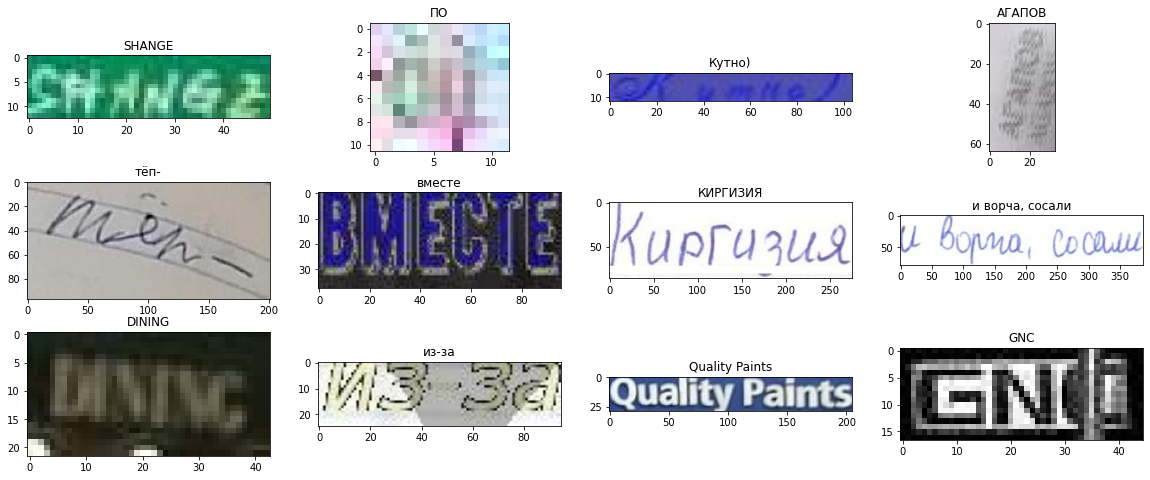

In [22]:
%matplotlib inline
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 8))

for axis in axes.flatten():
    rand_number = random.randint(0, len(images) - 1)
    axis.imshow(images[rand_number])
    axis.set_title(labels[rand_number])

# Preprocessing

## Remove words with OOD chars

In [23]:
labels_df = labels_df[~(labels_df['Expected']
                        .map(out_of_dict_elems.intersection)
                        .map(len) > 0)].reset_index(drop=True)
labels_df

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74
...,...,...
275297,275996.jpg,DO
275298,275997.jpg,BASUCC
275299,275998.jpg,"1,120"
275300,275999.jpg,"наблюдателей,"


## Rotate images so that width / height > 0.8

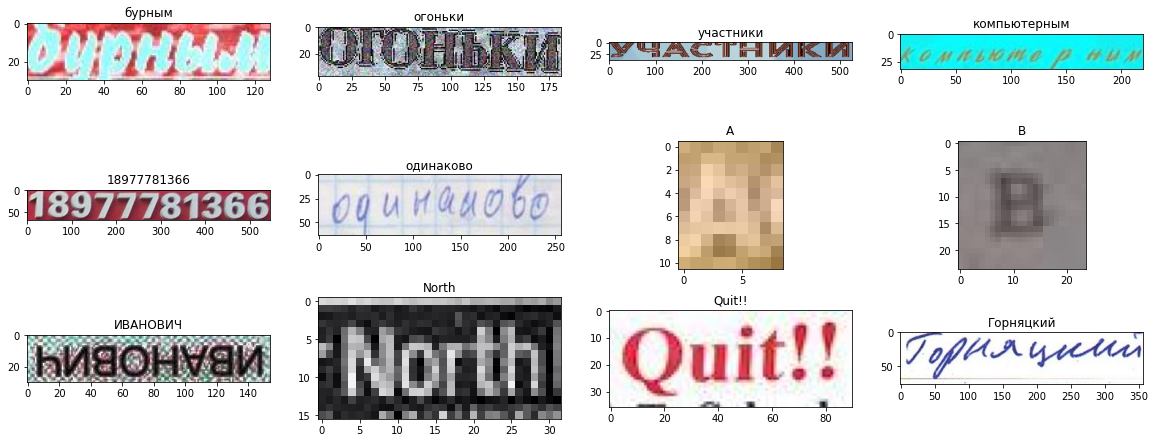

In [24]:
images = list(map(lambda x: x if x.shape[1] / x.shape[0] > 0.8 else np.transpose(x, (1, 0, 2)), images))

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 8))

for axis in axes.flatten():
    rand_number = random.randint(0, len(images) - 1)
    axis.imshow(images[rand_number])
    axis.set_title(labels[rand_number])

# Automate dataset load

In [22]:
class OCRTestDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        id_2_char,
        root_dir: str = os.path.join('..', 'data', 'raw', 'vk-made-ocr'),
        desired_width: int = 80,
        desired_height: int = 32,
        pad_token = '\\',
    ):
        super().__init__()
        self.root_dir = root_dir
        self.mode = 'test'
        self.path = Path(os.path.join(root_dir, self.mode, self.mode))
        self.width = desired_width
        self.height = desired_height
        self.labels = pd.read_csv(os.path.join(root_dir, 'sample_submission.csv')).fillna('')
        
        self.pad_token = pad_token
        self.id_2_char = id_2_char
        self.char_2_id = {char: id_ for id_, char in self.id_2_char.items()}
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx: int):
        path = self.path / self.labels.iloc[idx]['Id']
        
        with Image.open(path) as image_pil:
            image = image_pil \
                if image_pil.size[0] / image_pil.size[1] > 0.8 \
                else image_pil.transpose(Image.ROTATE_90)
            image = image.resize((self.width, self.height))
            image = torch.from_numpy(np.array(image).astype(np.float32) / 255).unsqueeze(0)
        
        image = image.permute((0, 3, 1, 2))
        
        return image, self.labels.iloc[idx]['Id']

In [23]:
dataset = OCRTrainDataset()
test_dataset = OCRTestDataset(id_2_char=dataset.id_2_char)

In [24]:
plt.imshow(test_dataset[10][0][0].permute((1, 2, 0))), test_dataset[10][1]

(<matplotlib.image.AxesImage at 0x7fdfbcea5340>, '11.jpg')

In [26]:
test_dataset[10][0][0]

tensor([[[0.8549, 0.8549, 0.8510,  ..., 0.8549, 0.8549, 0.8549],
         [0.8627, 0.8627, 0.8588,  ..., 0.8549, 0.8549, 0.8549],
         [0.8784, 0.8784, 0.8784,  ..., 0.8627, 0.8627, 0.8627],
         ...,
         [0.8667, 0.8667, 0.8706,  ..., 0.8588, 0.8588, 0.8588],
         [0.8431, 0.8471, 0.8549,  ..., 0.8510, 0.8510, 0.8510],
         [0.8353, 0.8392, 0.8471,  ..., 0.8510, 0.8510, 0.8510]],

        [[0.8824, 0.8824, 0.8784,  ..., 0.8941, 0.8941, 0.8941],
         [0.8902, 0.8902, 0.8863,  ..., 0.8941, 0.8941, 0.8941],
         [0.9059, 0.9059, 0.9059,  ..., 0.9020, 0.9020, 0.9020],
         ...,
         [0.8941, 0.8941, 0.8980,  ..., 0.8941, 0.8941, 0.8941],
         [0.8706, 0.8745, 0.8824,  ..., 0.8863, 0.8863, 0.8863],
         [0.8627, 0.8667, 0.8745,  ..., 0.8863, 0.8863, 0.8863]],

        [[0.8549, 0.8549, 0.8510,  ..., 0.8510, 0.8510, 0.8510],
         [0.8627, 0.8627, 0.8588,  ..., 0.8510, 0.8510, 0.8510],
         [0.8784, 0.8784, 0.8784,  ..., 0.8588, 0.8588, 0.

# DataLoader utils

In [27]:
def train_collate_fn(data, padding_value=0):
    images, labels, lengths = zip(*data)
    images = torch.cat(images)
    
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=padding_value)
    
    return images, labels, torch.tensor(lengths, dtype=torch.int32)

def test_collate_fn(data, padding_value=0):
    images, labels = zip(*data)
    images = torch.cat(images)
        
    return images, labels

In [28]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=train_collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=test_collate_fn)

In [31]:
batch = next(iter(train_dataloader))
batch[0].shape, batch[0].dtype, \
    batch[1].shape, batch[1].dtype, \
    batch[2].shape, batch[2].dtype, \
    next(iter(train_dataloader))[1]

(torch.Size([16, 3, 32, 80]),
 torch.float32,
 torch.Size([16, 14]),
 torch.int32,
 torch.Size([16]),
 torch.int32,
 tensor([[100,  46,  24,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [ 93,   3,   9,   1,   8,  18,   7,   7,   4,  19,   0,   0,   0],
         [ 53,   2,  27,   2,  57,   7,   6,   2,   5,   0,   0,   0,   0],
         [ 53,   2,  27,   2,  57,   7,   6,   2,   5,   0,   0,   0,   0],
         [100,  23,  34,  45,  33,  49,   0,   0,   0,   0,   0,   0,   0],
         [ 99,   4,   5,   2,   4,  13,   2,   0,   0,   0,   0,   0,   0],
         [ 17,   8,   3,  13,   7,   6,   2,  11,   9,  19,   9,   4,   0],
         [ 53,  21,  27,  21,   9,   1,   8,  13,   2,   0,   0,   0,   0],
         [ 82,  48,  61, 109, 112,  42,  52, 120,   0,   0,   0,   0,   0],
         [ 71,   2,   7,  57,   1,  36, 127,   0,   0,   0,   0,   0,   0],
         [ 68,   7,   3,  15,  59,  15,  12,  18,  44,   4,   6,   7,  19],
         [107,  95,  95,   3,  10,   6,   4,  11

In [32]:
batch = next(iter(test_dataloader))
batch[0].shape, batch[0].dtype, batch[1]

(torch.Size([16, 3, 32, 80]),
 torch.float32,
 ('9675.jpg',
  '17882.jpg',
  '11277.jpg',
  '20666.jpg',
  '3337.jpg',
  '16332.jpg',
  '24872.jpg',
  '10328.jpg',
  '48415.jpg',
  '23056.jpg',
  '50742.jpg',
  '26749.jpg',
  '37612.jpg',
  '32135.jpg',
  '29169.jpg',
  '24078.jpg'))

## CRNN

In [32]:
summary(CRNN(in_channels=3, num_classes=181), (128, 3, 32, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [24, 128, 181]            --
├─Sequential: 1-1                        [128, 512, 1, 24]         --
│    └─Conv2d: 2-1                       [128, 64, 32, 100]        1,792
│    └─MaxPool2d: 2-2                    [128, 64, 16, 50]         --
│    └─ReLU: 2-3                         [128, 64, 16, 50]         --
│    └─Conv2d: 2-4                       [128, 128, 16, 50]        73,856
│    └─MaxPool2d: 2-5                    [128, 128, 8, 25]         --
│    └─ReLU: 2-6                         [128, 128, 8, 25]         --
│    └─Conv2d: 2-7                       [128, 256, 8, 25]         295,168
│    └─ReLU: 2-8                         [128, 256, 8, 25]         --
│    └─Conv2d: 2-9                       [128, 256, 8, 25]         590,080
│    └─MaxPool2d: 2-10                   [128, 256, 4, 25]         --
│    └─ReLU: 2-11                        [128, 256, 4, 25]         -

In [66]:
dataset = OCRTrainDataset(desired_width=100, limit=256000, vocab_size=180)
submit_dataset = OCRTestDataset(id_2_char=dataset.id_2_char, desired_width=100)

batch_size = 128

len_test_set = len(dataset) // 50
train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset) - len_test_set, len_test_set], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    collate_fn=train_collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=512,
    num_workers=11,
    shuffle=False,
    collate_fn=train_collate_fn
)

submit_loader = torch.utils.data.DataLoader(
    submit_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    persistent_workers=True,
    collate_fn=test_collate_fn,
    pin_memory=True
)

In [67]:
print(len(dataset))

256000


In [11]:
crnn = CRNN(in_channels=3, num_classes=len(dataset.char_2_id))
crnn.to(device)

CRNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

In [12]:
optimizer = torch.optim.Adadelta(crnn.parameters(), lr=1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
criterion = nn.CTCLoss(zero_infinity=True)
criterion.to(device)

CTCLoss()

## Training process

<IPython.core.display.Javascript object>


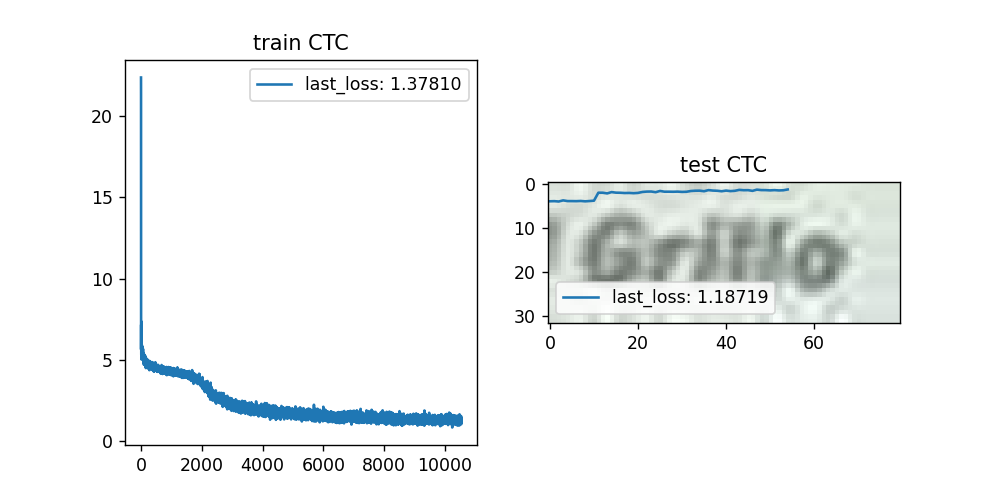

  0%|                                                                                          | 0/2108 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [14]:
%matplotlib notebook
losses = train_model_ctc(
    model=crnn,
    id_2_char=dataset.id_2_char,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=20
)

<IPython.core.display.Javascript object>


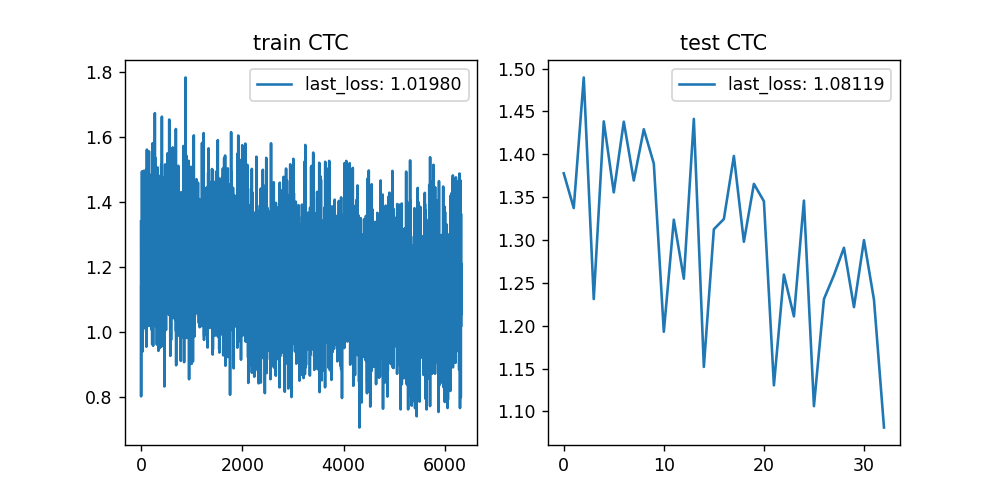

  0%|                                                                                          | 0/2108 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [61]:
%matplotlib notebook
losses = train_model_ctc(
    model=crnn,
    id_2_char=dataset.id_2_char,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=10
)

<IPython.core.display.Javascript object>


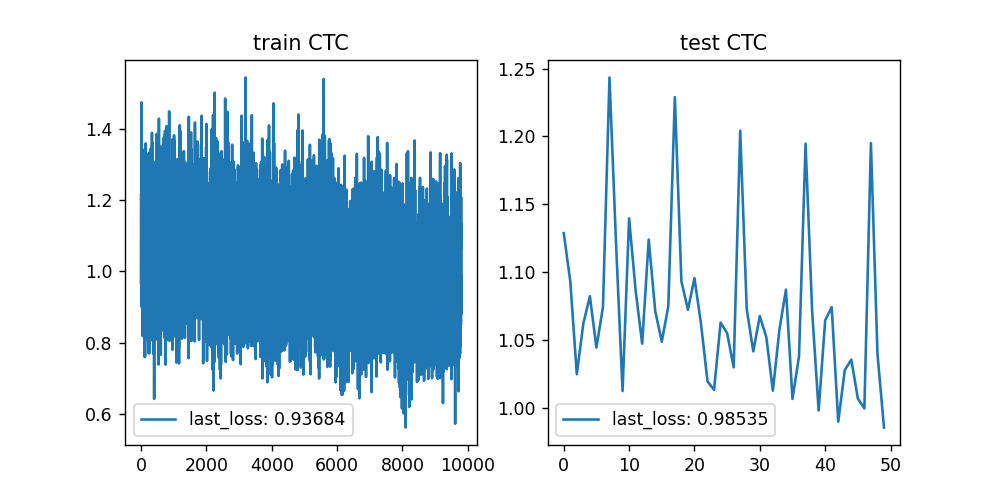

100%|███████████████████████████████████████████████████████████████████████████████| 1960/1960 [07:40<00:00,  4.26it/s]


In [68]:
losses = train_model_ctc(
    model=crnn,
    id_2_char=dataset.id_2_char,
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=5
)

In [69]:
torch.cuda.empty_cache()

## Evaluation process

In [70]:
crnn.eval()

predictions = []
ground_truth = []
with torch.no_grad():
    for data in tqdm(test_loader):
        images, targets, target_lengths = [elem.to(device) for elem in data]

        logits = crnn(images)

        # recall that dims are (width, bsize, num_classes)
        log_probas = f.log_softmax(logits, dim=2)

        input_lengths = torch.tensor([logits.size(0)] * logits.size(1), dtype=torch.int32)

        loss = criterion(log_probas, targets, input_lengths, target_lengths)

        # decoding net's results
        for pred_probas, true_res in zip(log_probas.permute((1, 0, 2)), targets):
            pred = torch.argmax(pred_probas, axis=1)
            pred = torch.unique_consecutive(pred)
            char_pred = [dataset.id_2_char[elem.item()] for elem in pred if dataset.id_2_char[elem.item()] != '\\']

            res_str = ''.join(char_pred)

            target_decoded = [dataset.id_2_char[elem.item()] for elem in true_res if dataset.id_2_char[elem.item()] != '\\']
            target_decoded = ''.join(target_decoded)
            
            predictions.append(res_str)
            ground_truth.append(target_decoded)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


In [72]:
char_error_rate(predictions, ground_truth)

tensor(0.2743)

In [71]:
list(zip(predictions, ground_truth))

[('ARF', 'ARE'),
 ('доверили', 'доверили'),
 ('JEL:37691618', 'TEL:37691618'),
 ('Мостара', 'Мостара'),
 ('ЦёЭ-щ9_1)', 'ЦбЭ–щя_г$'),
 ('Элбинсский', 'Эльбингский'),
 ('HUT', 'HUT'),
 ('1647', '1647'),
 ('35,643', '35,643'),
 ('улетела', 'улетела'),
 ('условиям', 'условиям'),
 ('AHEAD', 'AHEAD'),
 ('№т.’(ра:01зс', 'Жт_`(ра:0)зс'),
 ('ЭСТРАДА', 'ЭСТРАДА'),
 ('обласТь,', 'обласТь,'),
 ('взыскания', 'взыскания'),
 ('ASI LOSRI', 'ALEKSEY NESHCHADIN'),
 ('JUICE', 'JUICE'),
 ('356,', '356,'),
 ('RFASRS', 'RFASRS'),
 ('главе', 'главе'),
 ('коса', 'коса'),
 ('TEL.', 'TEL.'),
 ('олотоню', 'гостиную'),
 ('Роверят', 'Говорят'),
 ('PREMIUM', 'PREMIUM'),
 ('Y', 'Creme'),
 ('Сарзедам', 'Сарзедаш'),
 ('ОСООВВА', 'ЗАВОДСКОМ'),
 ('с.', 'с.'),
 ('ЧЕТЫРЕХ', 'четырех'),
 ('летечант', 'лейтенант'),
 ('пувиыт', 'длительный'),
 ('20', '2017'),
 ('R-D', 'R-D'),
 ('ГОР.', 'ГОР.'),
 ('18804987617', '13804987617'),
 ('B', 'BY'),
 ('Шуба', 'Шуба'),
 ('стрельцами,', 'стрельцами,'),
 ('жааж', 'Жаркое'),
 ('привела-'

In [73]:
def predict_model(
    model: CRNN,
    dataloader: torch.utils.data.DataLoader,
    id_2_char: Dict[int, str]
) -> Dict[str, str]:
    
    model.eval()
    predictions = {}
    for data in tqdm(dataloader):
        images, filenames = data
        images = images.to(device)
        logits = model(images)
        log_probas = f.log_softmax(logits, dim=2)
        input_lengths = torch.tensor([logits.size(0)] * logits.size(1), dtype=torch.int32)
        
        # decoding net's results
        for pred_probas, filename in zip(log_probas.permute((1, 0, 2)), filenames):
            pred = torch.argmax(pred_probas, axis=1)
            pred = torch.unique_consecutive(pred)
            char_pred = [id_2_char[elem.item()] for elem in pred if id_2_char[elem.item()] != '\\']

            res_str = ''.join(char_pred)
            
            predictions[filename] = res_str
        
    return predictions

In [74]:
predictions = predict_model(crnn, submit_loader, dataset.id_2_char)
predictions

100%|█████████████████████████████████████████████████████████████████████████████████| 415/415 [01:37<00:00,  4.26it/s]


{'1.jpg': 'роду,',
 '2.jpg': '1',
 '3.jpg': 'LAISHANG BANK',
 '4.jpg': 'Mokelumne',
 '5.jpg': 'BAO',
 '6.jpg': '53SU',
 '7.jpg': '18817747472',
 '8.jpg': 'G',
 '9.jpg': 'AUSTRALIAN',
 '10.jpg': '94',
 '11.jpg': 'Grillo',
 '12.jpg': '2',
 '13.jpg': 'FAIR',
 '14.jpg': 'C1M-3E5389',
 '15.jpg': 'ME/AGE',
 '16.jpg': 'ay',
 '17.jpg': 'г',
 '18.jpg': 'хорош',
 '19.jpg': 'cooperativa',
 '20.jpg': 'TR wR ',
 '21.jpg': '2-11',
 '22.jpg': 'бате',
 '23.jpg': '1943,',
 '24.jpg': 'томах.',
 '25.jpg': '1O',
 '26.jpg': 'TAIWAN',
 '27.jpg': '4011',
 '28.jpg': 'CoMoe',
 '29.jpg': 'across',
 '30.jpg': 'Nero',
 '31.jpg': 'LBEKTTS',
 '32.jpg': 'lицей',
 '33.jpg': 'илользуе',
 '34.jpg': 'BE',
 '35.jpg': 'ROn',
 '36.jpg': 'FiLu',
 '37.jpg': 'прекрасное',
 '38.jpg': 'и10-88',
 '39.jpg': 'Midv',
 '40.jpg': '120',
 '41.jpg': '86E',
 '42.jpg': 'рочта Воссках',
 '43.jpg': 'RRHETON',
 '44.jpg': 'своего',
 '45.jpg': 'баалы',
 '46.jpg': 'M.,',
 '47.jpg': 'родгелия',
 '48.jpg': '1g8п',
 '49.jpg': 'EESIGM',
 '50.jpg':

In [75]:
submit = pd.read_csv('../data/raw/vk-made-ocr/sample_submission.csv')
for key in tqdm(predictions):
    submit.loc[submit['Id'] == key, 'Predicted'] = predictions[key]

100%|████████████████████████████████████████████████████████████████████████████| 52999/52999 [01:45<00:00, 503.34it/s]


In [76]:
submit

,Id,Predicted
0,1.jpg,"роду,"
1,2.jpg,1
2,3.jpg,LAISHANG BANK
3,4.jpg,Mokelumne
4,5.jpg,BAO
...,...,...
52994,52996.jpg,алнаия
52995,52997.jpg,TUAN
52996,52998.jpg,1505
52997,52999.jpg,Г


In [77]:
submit.to_csv('submission_2.csv', index=False)

In [54]:
list(zip(
    [''.join([elem for elem in pred if elem != '\\']) for pred in predictions],
    [''.join([elem for elem in gt if elem != '\\']) for gt in ground_truth]))

[('азлетиену', '23-летнему'),
 ('Cл}', 'СайТ'),
 ('Eiotss', 'RESTROSPECTIVE'),
 ('Хрыновыи', 'Хрыновым'),
 ("d'art.", "d'art."),
 ('ббдин', 'большой'),
 ('фбе', 'обл'),
 ('ReQIE', 'Boroplast'),
 ('Актау', 'Актау'),
 ('B900', '3900'),
 ('отрубншшеть', 'сотрудничество'),
 ('выполнип.', 'выполнил.'),
 ('прераенний', 'прекрасный'),
 ('1302219621', '13022191621'),
 ('1592683021', '15926430212'),
 ('Shuongshuong', 'ShuangShuang'),
 ('ою-ReMi', 'Do Re Mi'),
 ('дозоватам', 'розоватым'),
 ('о.', 'Д.'),
 ('13927394733', '13927394733'),
 ('пящуля', 'тянулся'),
 ('отаматаны тре', 'осталось только три'),
 ('Mns', 'vines'),
 ('CIEHIHAHMIAFGO MMID', 'Shanghai Withub Hi-tech Business Incubator'),
 ('MENYa', 'DAVID'),
 ('ТоедуGноTель', 'Предусмотреть'),
 ('едвкми', 'здание'),
 ('CE', 'CE'),
 ('Van', 'Van'),
 ('манеринанюю', 'материального'),
 ('МРЕССбС', 'состояние.бортики'),
 ('"ДъзИ-ЖшшГ', '*ДъЭ4:,%(цш-'),
 ('сркезотжк', 'саквояж'),
 ('Тееи,', 'ожесточённых'),
 ('доваь', 'новые'),
 ('TRANSPORI', 'TRA

In [78]:
SAVE_PATH = 'crnn_good_2_w_optimizer.pth'
torch.save({
    'model_state_dict': crnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, SAVE_PATH)

### Consider running the cell below if you suddenly ran out of GPU memory.

In [117]:
import gc

gc.collect()
torch.cuda.empty_cache()